# Поиск аномалий

Рассматривается вариант обучения без учителя на данных  [superstore](https://community.tableau.com/s/question/0D54T00000CWeX8SAL/sample-superstore-sales-excelxls)

### Загрузка библиотек и данных

In [25]:
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import pandas as pd
import seaborn as sns
from sklearn.ensemble import IsolationForest
df = pd.read_excel("Superstore.xls")

### Рассмотрим одномерные распределения и аномалии

Рсапределние продаж

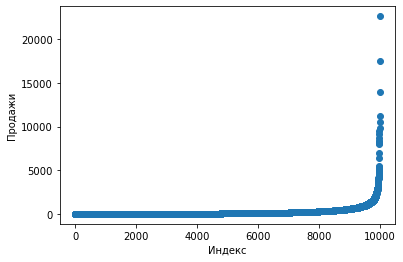

In [26]:
fig = plt.scatter(range(df.shape[0]), np.sort(df['Sales'].values))
plt.xlabel('Индекс')
plt.ylabel('Продажи')
plt.show(fig)

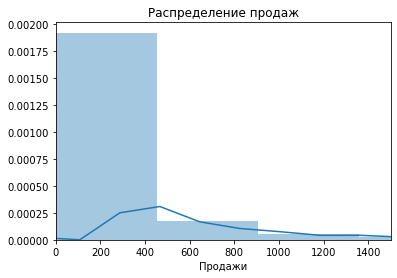

In [27]:
fig = sns.distplot(df['Sales'])
plt.title("Распределение продаж")
fig.set(xlim=(0, 1500))
plt.xlabel('Продажи')
plt.show(fig)

Можно заметить что рапспределение не является нормальным \
Так-же можно предположить, что регион с низкой вероятностю будет являться аномалией

Используем алгоритм isolation forest для поиска аномали в данном рапределении, с следующим порядком действий\
- Обучение IsolationForest с использованием данных о продажах
- Вычисление значения аномалии для каждого наблюдения  
- Классификация каждого наблюдения как аномалии или нормы
- Визуализация регионов

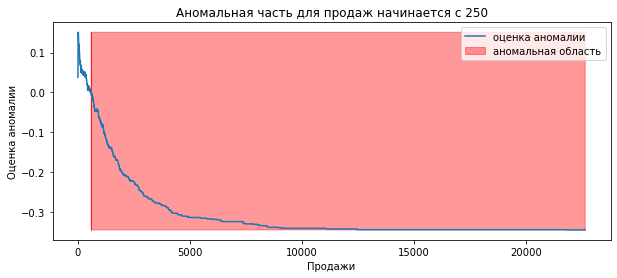

In [28]:
isolation_forest = IsolationForest(n_estimators=100, behaviour="new", contamination = 0.1)
isolation_forest.fit(df['Sales'].values.reshape(-1, 1))
xx = np.linspace(df['Sales'].min(), df['Sales'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
fig, ax = plt.subplots(figsize=(10,4))
plt.plot(xx, anomaly_score, label='оценка аномалии')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='аномальная область')
plt.legend()
plt.ylabel('Оценка аномалии')
plt.xlabel('Продажи')
plt.title(f"Аномальная часть для продаж начинается с {outlier.tolist().index(-1)}")
plt.show();

Проверяем значения дохода схожим методом

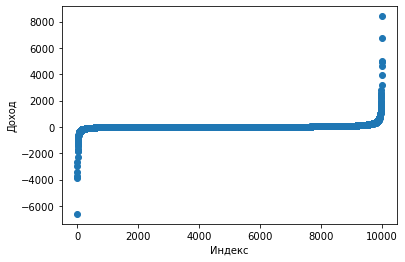

In [29]:
fig = plt.scatter(range(df.shape[0]), np.sort(df['Profit'].values))
plt.xlabel('Индекс')
plt.ylabel('Доход')
plt.show(fig)

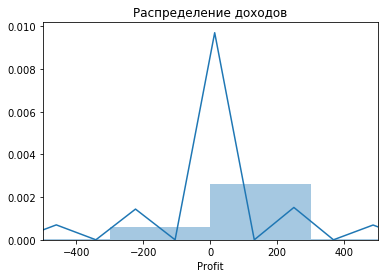

In [30]:
fig = sns.distplot(df['Profit'])
plt.title("Распределение доходов")
fig.set(xlim=(-500, 500))
plt.show(fig)

Рсапределение ближе к нормальному \
Два аномлаьных региона - отрицательный и положительный

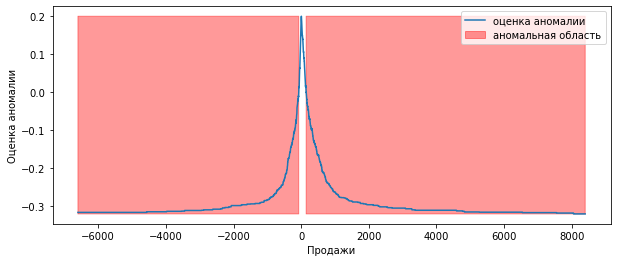

In [31]:
isolation_forest = IsolationForest(n_estimators=100, behaviour="new", contamination = 0.1)
isolation_forest.fit(df['Profit'].values.reshape(-1, 1))
xx = np.linspace(df['Profit'].min(), df['Profit'].max(), len(df)).reshape(-1,1)
anomaly_score = isolation_forest.decision_function(xx)
outlier = isolation_forest.predict(xx)
plt.figure(figsize=(10,4))
plt.plot(xx, anomaly_score, label='оценка аномалии')
plt.fill_between(xx.T[0], np.min(anomaly_score), np.max(anomaly_score), 
                 where=outlier==-1, color='r', 
                 alpha=.4, label='аномальная область')
plt.legend()
plt.ylabel('Оценка аномалии')
plt.xlabel('Продажи')
plt.show();

### Многомерный случай

Рассмотрим соотношение доходов и продаж

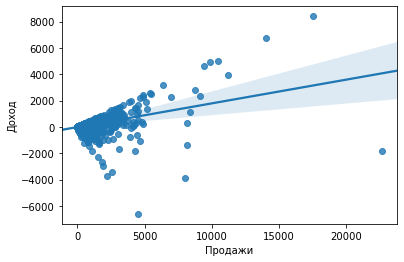

In [32]:
fig = sns.regplot(x="Sales", y="Profit", data=df)
plt.ylabel('Доход')
plt.xlabel('Продажи')
plt.show(fig)

Используется библиотека [PyOD](https://pyod.readthedocs.io/en/latest/)

In [33]:
from utils import plot_ad
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA

Задаются параметры и модели \
В данном случае аномальным считаем 1% от общего числа данных 

In [34]:
outliers = 0.01
random_state = 42
classifiers = {
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers,
              check_estimator=False, random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers),
    'Isolation Forest': IForest(contamination=outliers,
                                behaviour="new",
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers),
    'Average KNN': KNN(method='mean',
                       contamination=outliers),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers, random_state=random_state)
}

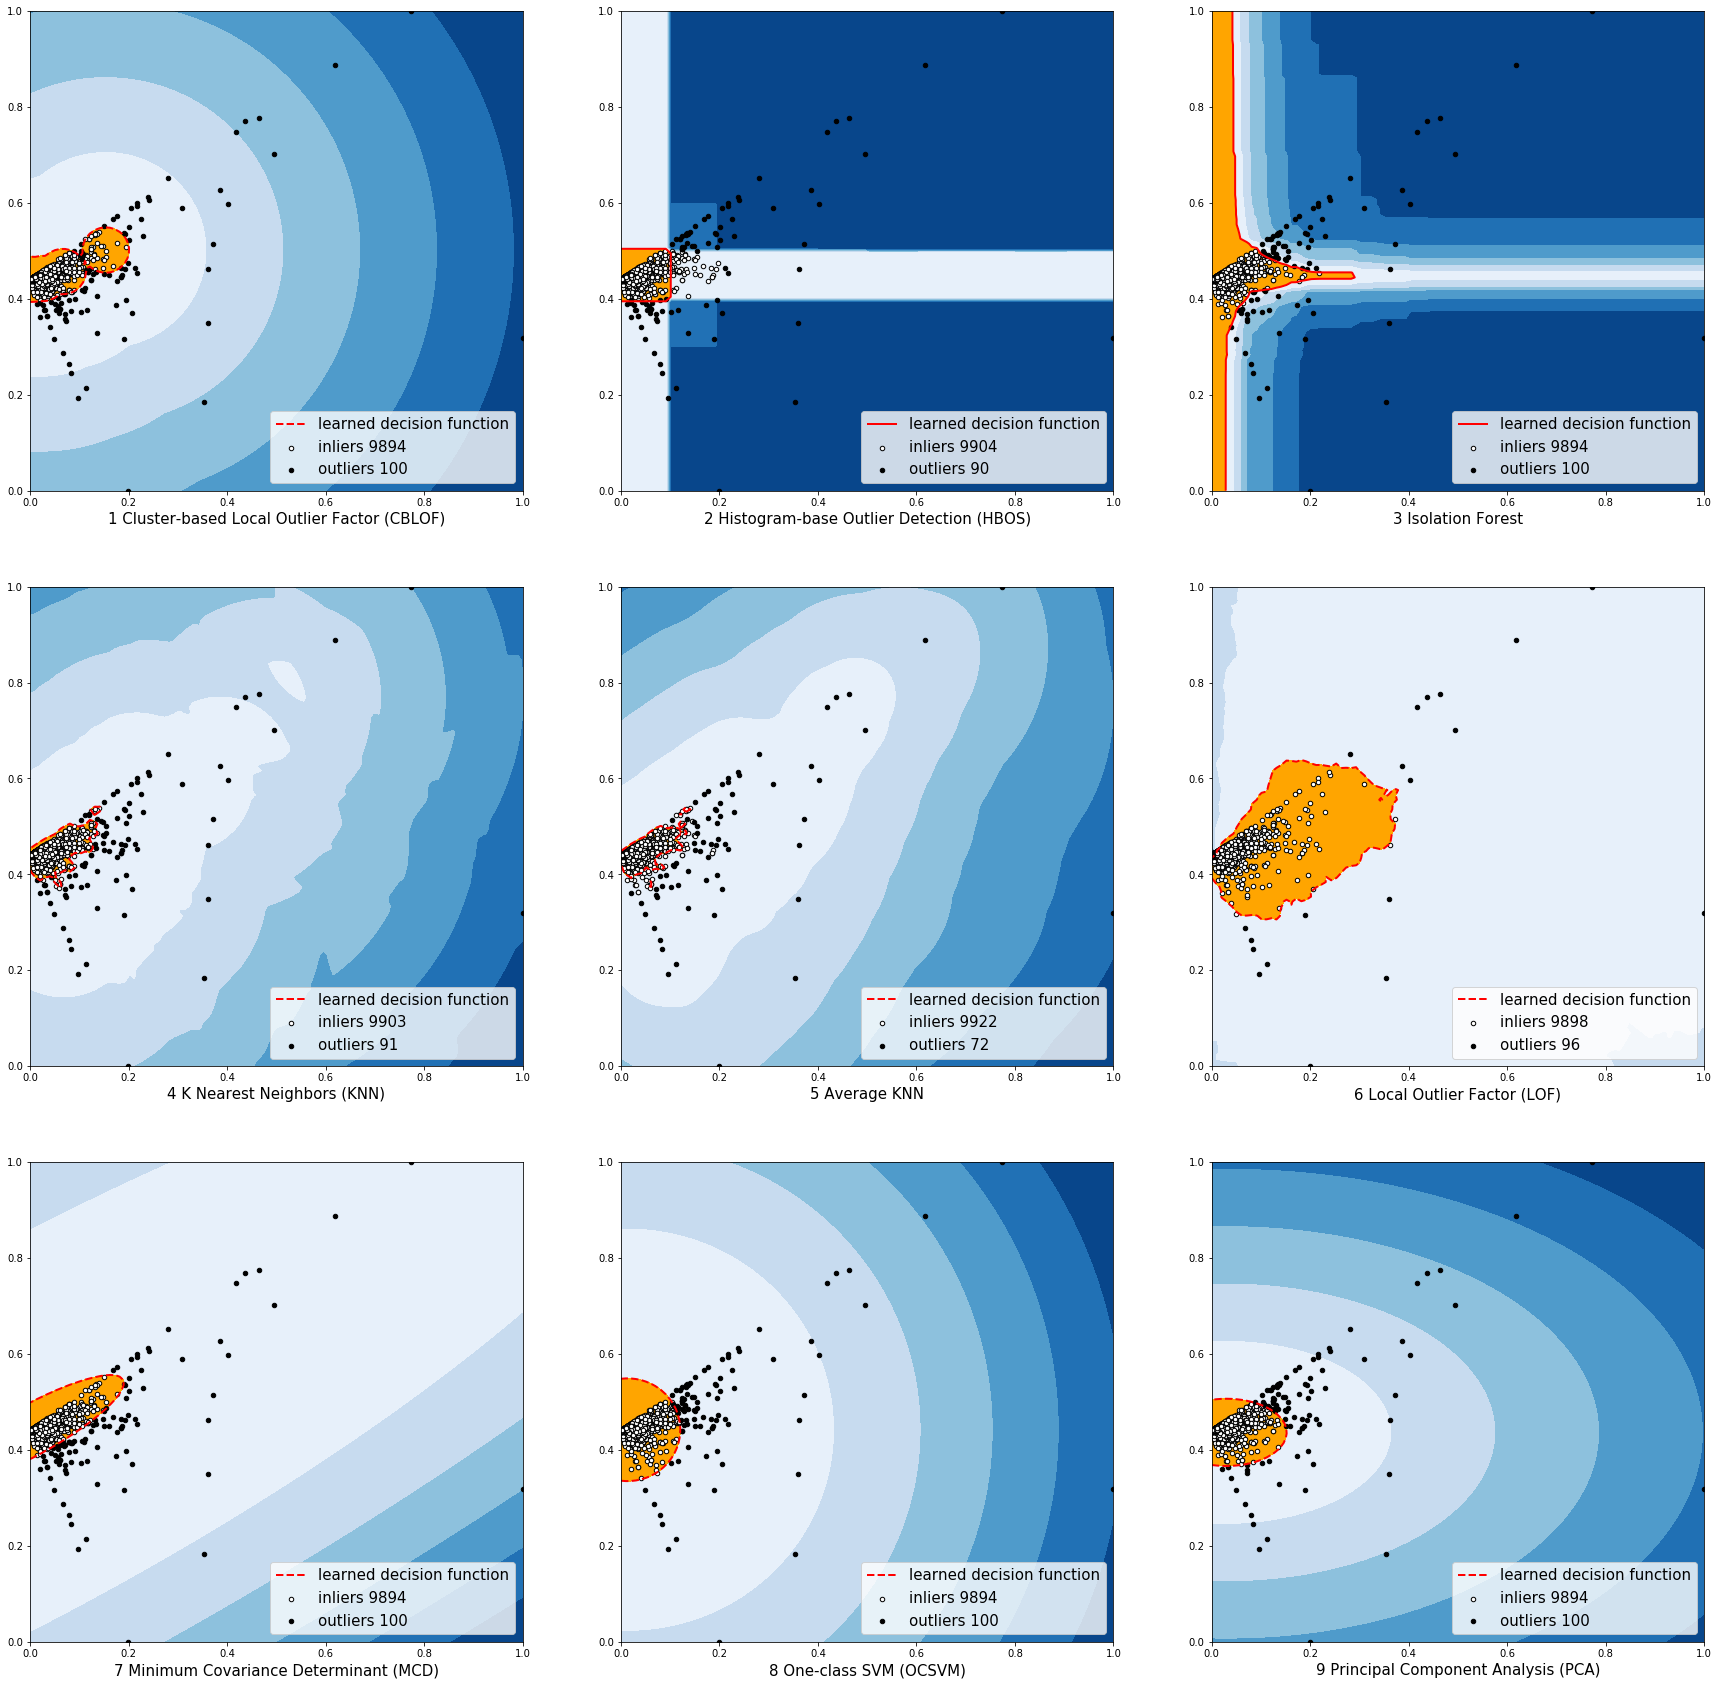

In [35]:
fig = plot_ad(df = df, models = classifiers, outliers_fraction = outliers)
fig